In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch

import numpy as np
import cv2
from src.voc_dataset import *
from src.region_proposal import RegionProposalNetwork, get_target_weights
from src.generate_anchor_data import AnchorDataGenerator
from src.generate_anchors import generate_anchors
from src.anchor_util import generate_all_anchors
from src.proposal import ProposalGenerator
from src.recall import recall

import pickle

In [2]:
dataset = VOCDataSet("data/", "train", include_gt_lable=True, include_difficult_gt=False)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=collate_fn)

In [8]:
#checkpoint = torch.load("data/Experiments/train_test/checkpoints/checkpoint_0.tar")
#checkpoint = torch.load("data/Experiments/train_10_epoch_updated_loss/checkpoints/checkpoint_9.tar")
checkpoint = torch.load("data/Experiments/train_with_lr_decay/checkpoints/checkpoint_7.tar")

rpn = RegionProposalNetwork()
rpn.load_state_dict(checkpoint["state_dict"])
anchor_layer = AnchorDataGenerator()
proposal = ProposalGenerator()
softmax_m = nn.Softmax2d()
iterator = iter(dataloader)

[[ 0.31162052  0.7093064 ]
 [ 0.43315915  0.51552126]
 [ 0.92310324  0.22162228]
 ..., 
 [ 0.10393861  0.04118554]
 [ 0.07768815  0.        ]
 [ 0.11576761  0.        ]]
100.0


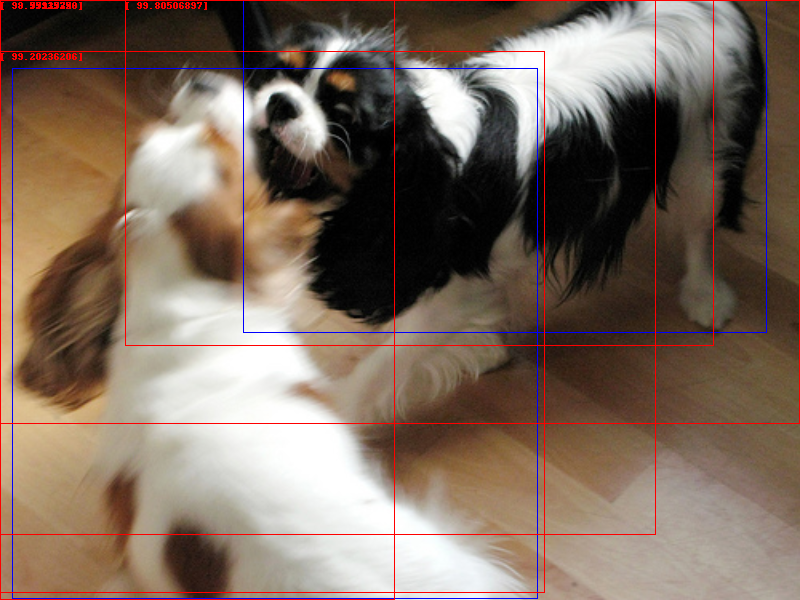

In [7]:
"""with open("/home/hnguyen/Wordspace/playground/fail_image.pkl", "rb") as f:
    image_arr, gt = pickle.load(f)
image_arr = Variable(torch.Tensor(image_arr))
gt = Variable(torch.Tensor(gt))"""
image_arr, gt, image_info, _ = iterator.next()
image_arr = Variable(image_arr)
gt = Variable(gt)

logits, regressions = rpn(image_arr)
logits = logits.view(1, 2, 9 * logits.size(2), logits.size(3))
scores = softmax_m(logits)

width = Variable(torch.Tensor([logits.size(3)]))                                                                                                                   
height = Variable(torch.Tensor([logits.size(2)]))
bboxes, scores = proposal(regressions, scores, image_info)

image = image_arr.cpu().data.numpy()
image = image.squeeze().transpose(1, 2, 0) + PIXEL_MEANS
image = image.round().astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")
    
pred_bbox = bboxes.data.numpy()
pred_score = scores.data.numpy()

for i in range(5):
    image_draw.text(pred_bbox[i, 1:3], str(pred_score[i] * 100.), fill="red")
    image_draw.rectangle(pred_bbox[i, 1:], outline="red")
    
print(recall([(pred_bbox[:, 1:], true_bbox)])[0] * 100.)

image

[[  5.81228110e-01   3.64537412e-01]
 [  4.06279911e-01   5.69036004e-01]
 [  7.83178164e-01   2.44219648e-01]
 [  3.54828435e-01   5.70530908e-01]
 [  4.76211848e-01   4.58102350e-01]
 [  6.35246170e-01   9.57259768e-02]
 [  2.75050921e-01   1.27072166e-01]
 [  3.76083955e-01   5.97589509e-01]
 [  4.12307087e-01   1.94452061e-01]
 [  4.61111643e-01   3.51011043e-02]
 [  5.12732768e-01   3.37321704e-01]
 [  6.85184752e-01   3.22252388e-01]
 [  2.88293416e-01   4.64075926e-02]
 [  2.30165195e-01   0.00000000e+00]
 [  4.02218033e-01   5.02219045e-01]
 [  6.99274063e-01   2.26263799e-01]
 [  1.53693673e-01   0.00000000e+00]
 [  3.69557674e-01   4.81622155e-01]
 [  1.33057855e-01   0.00000000e+00]
 [  6.43546275e-01   1.96078373e-01]
 [  5.22066844e-01   3.44436575e-01]
 [  4.96531403e-01   3.95367457e-01]
 [  5.92523167e-01   2.88310328e-01]
 [  3.58406771e-01   4.03784743e-01]
 [  5.23356584e-01   2.28971430e-01]
 [  4.62489370e-01   1.06068513e-01]
 [  5.86219385e-01   3.87994369e-01]
 

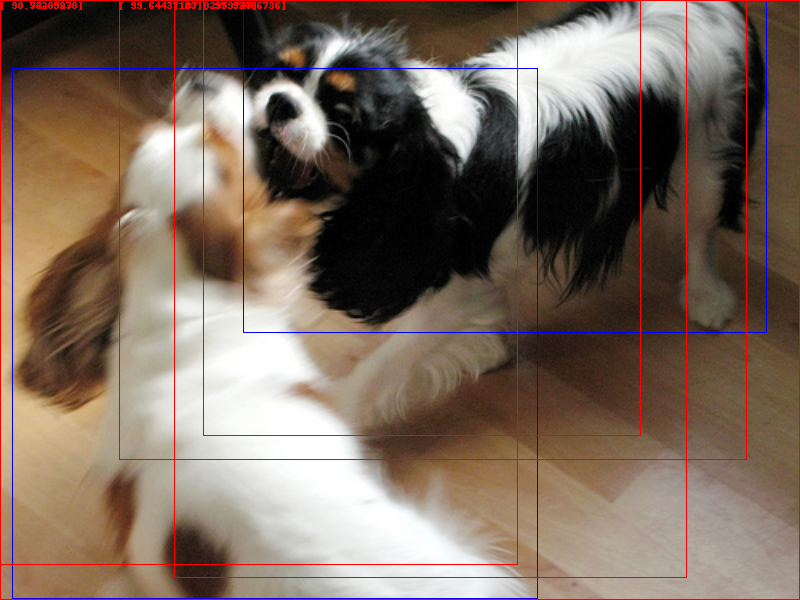

In [9]:
logits, regressions = rpn(image_arr)
logits = logits.view(1, 2, 9 * logits.size(2), logits.size(3))
scores = softmax_m(logits)

width = Variable(torch.Tensor([logits.size(3)]))                                                                                                                   
height = Variable(torch.Tensor([logits.size(2)]))
bboxes, scores = proposal(regressions, scores, image_info)

image = image_arr.cpu().data.numpy()
image = image.squeeze().transpose(1, 2, 0) + PIXEL_MEANS
image = image.round().astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")
    
pred_bbox = bboxes.data.numpy()
pred_score = scores.data.numpy()

for i in range(5):
    image_draw.text(pred_bbox[i, 1:3], str(pred_score[i] * 100.), fill="red")
    image_draw.rectangle(pred_bbox[i, 1:], outline="red")
    
print(recall([(pred_bbox[:, 1:], true_bbox)])[0] * 100.)

image